In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import VotingClassifier,StackingClassifier

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import Ridge, LinearRegression, Lasso
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
import lightgbm as lgb

import optuna

In [3]:
def data_frame_info(df):
    print(f"Shape: {df.shape}")
    print("Columns:")
    print(df.columns)
    print("Dtypes:")
    print(df.dtypes)
    print(f"Missing values:")
    print(df.isnull().sum())
    print(df.describe())
    print("Unique Vals:")
    print(df.nunique())
    print("Head:")
    print(df.head())

In [4]:
train_df=pd.read_csv("/kaggle/input/playground-series-s4e6/train.csv")
test_df=pd.read_csv("/kaggle/input/playground-series-s4e6/test.csv")

In [5]:
data_frame_info(train_df)

Shape: (76518, 38)
Columns:
Index(['id', 'Marital status', 'Application mode', 'Application order',
       'Course', 'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved

In [6]:
RUN_BASELINE=False
if RUN_BASELINE:
    X_train=train_df.copy()
    y_train=X_train.pop("Target")
    X_test=test_df.copy()
    model = CatBoostClassifier()
    model.fit(X_train,y_train, verbose=False)
    y_pred=model.predict(X_test)
    submission=pd.read_csv("/kaggle/input/playground-series-s4e6/sample_submission.csv")
    submission["Target"]=pd.DataFrame(y_pred)
    submission.to_csv('/kaggle/working/submission.csv',index=False)

# EDA

In [7]:
features=train_df.columns
features=list(features)
features.pop(-1)
features.pop(0)
categorical_features=['Marital status', 'Application mode', 'Application order',
       'Course', 'Daytime/evening attendance', 'Previous qualification',
        'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation",
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (without evaluations)']
target="Target"


In [ ]:
px.histogram(train_df,x=target)

In [9]:
px.pie(train_df,names=target, title="Target distribution")

In [10]:
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(train_df.Target)

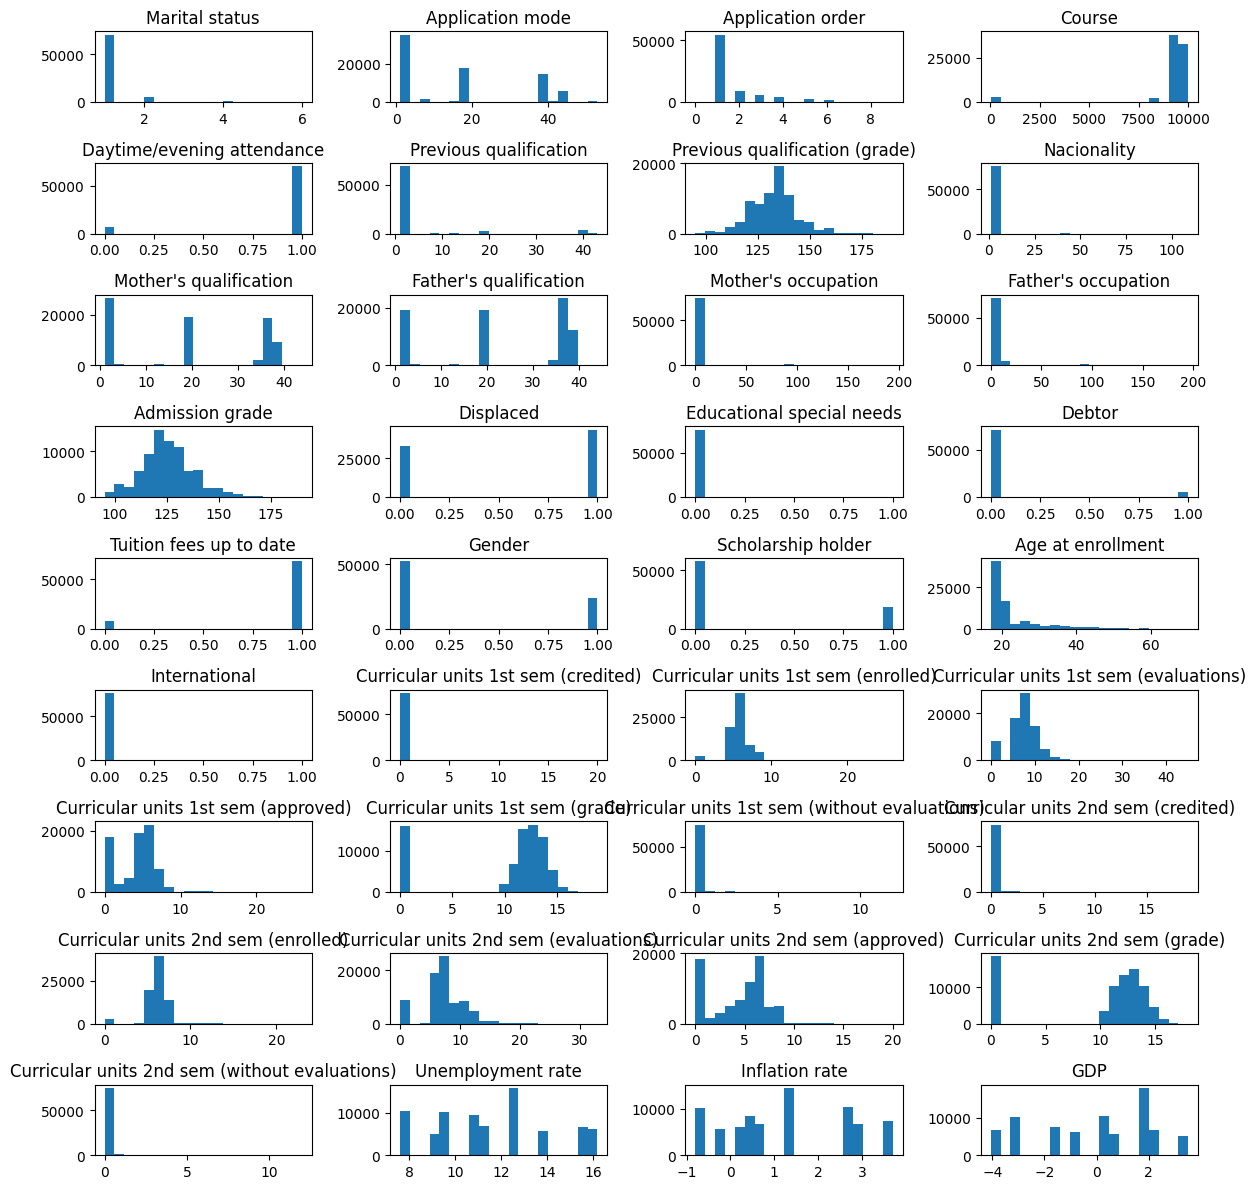

In [11]:
fig, axs = plt.subplots(9, 4,figsize=(12, 12))
for i,feature in enumerate(features):
    axs[i//4,i%4].hist(train_df[feature],bins=20)
    axs[i//4,i%4].set_title(feature)
plt.tight_layout()
plt.show()

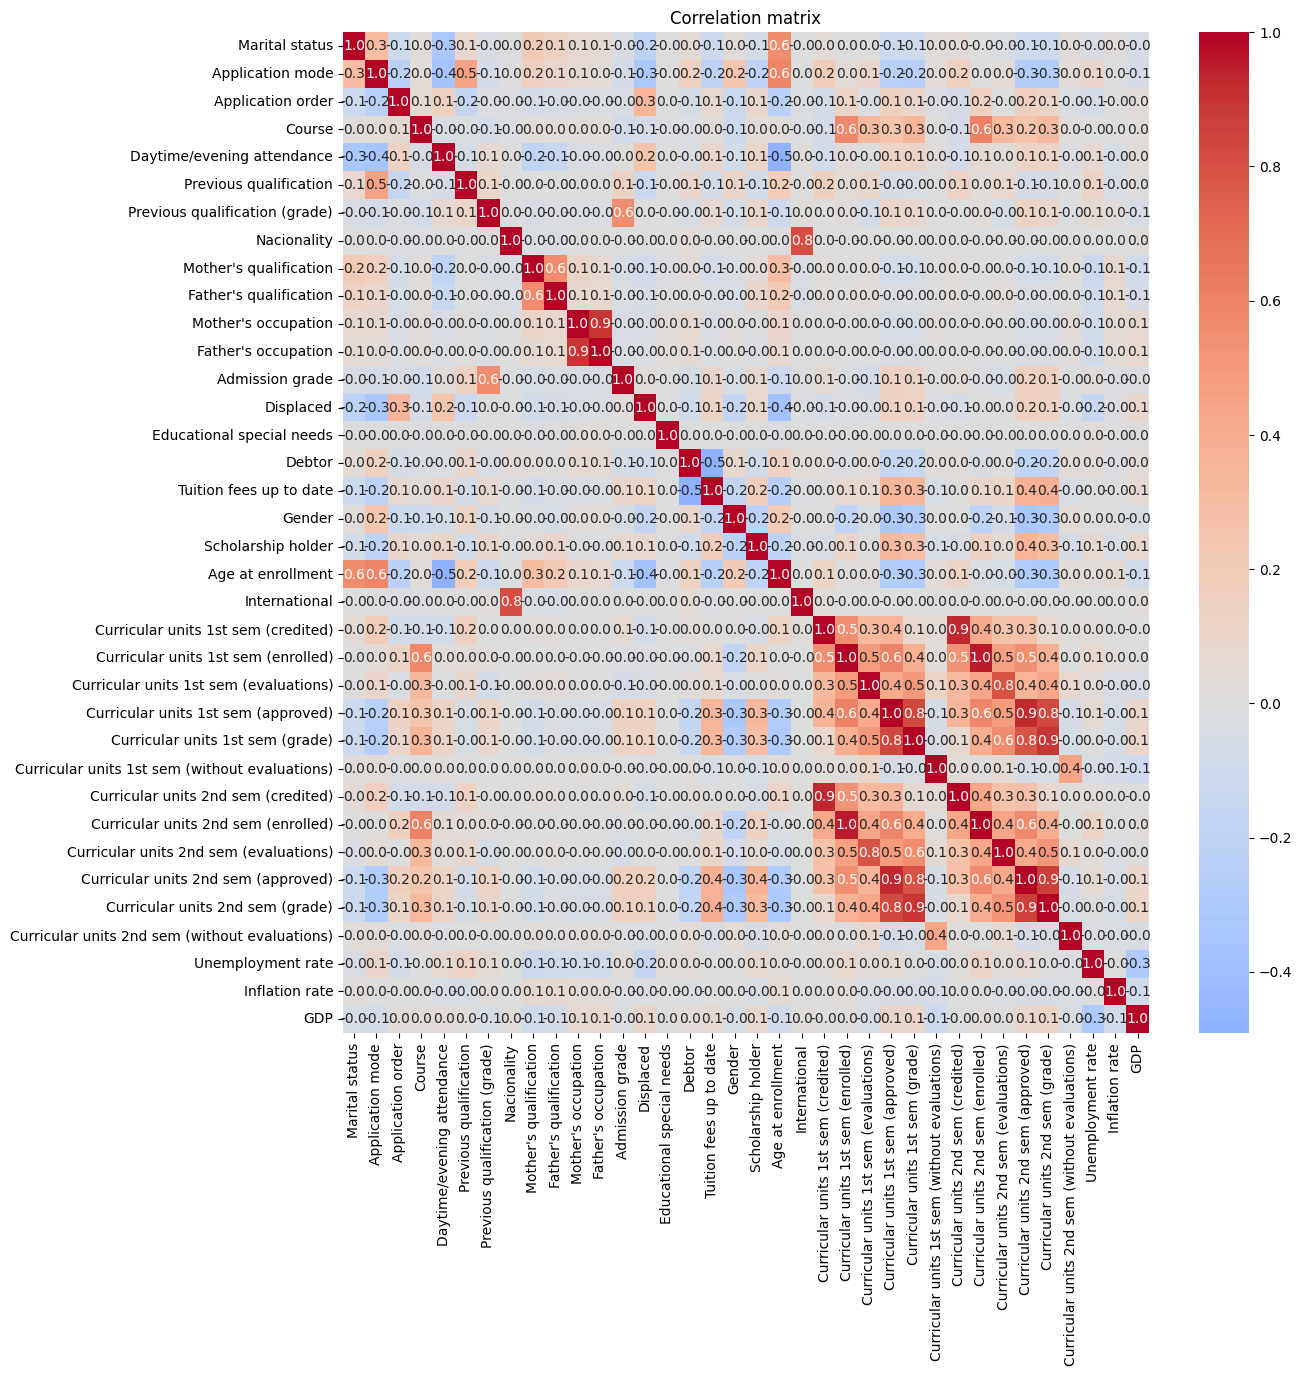

In [12]:
corr_features = features
cc = np.corrcoef(train_df[corr_features], rowvar=False)
plt.figure(figsize=(13, 13))
sns.heatmap(cc, center=0, cmap='coolwarm', annot=True, fmt='.1f',
            xticklabels=corr_features, yticklabels=corr_features)
plt.title('Correlation matrix')
plt.show()

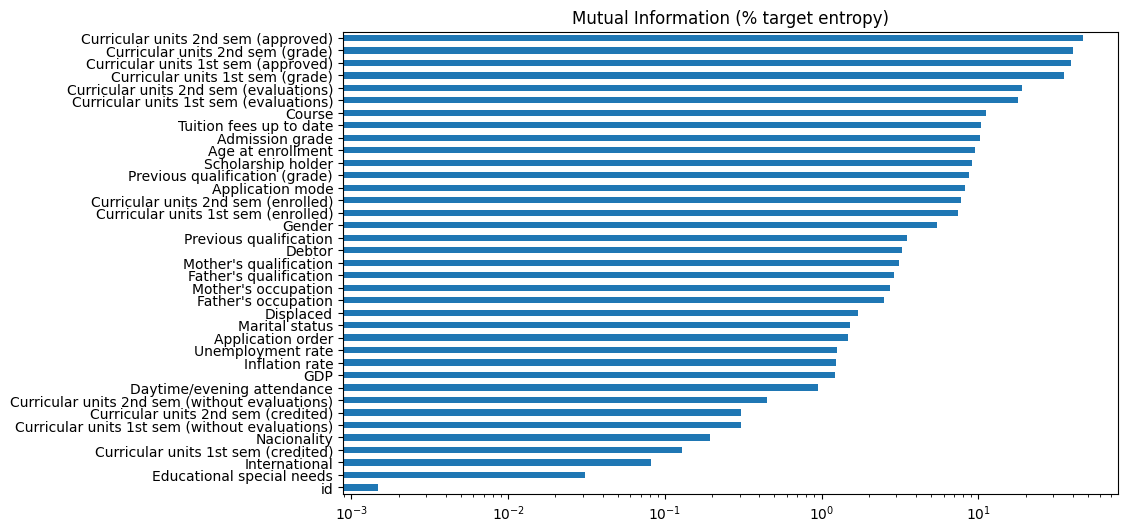

In [13]:
X=train_df.copy()
y=LabelEncoder().fit_transform(X.pop('Target'))

entr = mutual_info_classif(y[:,np.newaxis], y, discrete_features=True)[0]
mi = 0
for i in range(5):
    mi += pd.Series(mutual_info_classif(X, y, random_state=i)/entr,
                  index=X.columns)
ax = (mi/5*100).sort_values(ascending=False).plot(kind='barh',figsize=(10,6), logx=True)
ax.invert_yaxis()
ax.set_title('Mutual Information (% target entropy)')
plt.show()

In [14]:
def cross_validation(model, X, y, n_folds=5):
    kf=KFold(n_splits=n_folds,shuffle=True)
    scores=[]
    for train_index, test_index in kf.split(X,y):
        X_train,X_val=X.iloc[train_index],X.iloc[test_index]
        y_train,y_val=y.iloc[train_index],y.iloc[test_index]
        model.fit(X_train,y_train)
        y_pred=model.predict(X_val)
        scores.append(accuracy_score(y_val,y_pred))
    print(f"scores: {scores}")
    print(f"Average: {sum(scores)/len(scores)}")

# Models